In [1]:
import ROOT
from ROOT import TCanvas, TPad, TFile, TPaveLabel, TPaveText, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem, RDataFrame

import pandas as pd
from multiprocessing import Pool
import random
import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import multiprocessing as mp 
import pickle
from scipy.optimize import curve_fit
from sklearn.neighbors import KNeighborsRegressor

from scipy import stats
from scipy.stats import crystalball

from sklearn.neighbors import LocalOutlierFactor

from sklearn import preprocessing

from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [354]:
data = RDataFrame("t1", "photons_FullSim.root").AsNumpy()

In [355]:
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"]
        #data["part_z"],
        #data["part_theta"],
        #data["part_phi"]
    ]
).transpose()
y = data["cl_E_ecal"]
del data

In [228]:
sel_ind = (X.transpose()[3]>12280)*(X.transpose()[3]<12300) # np.random.choice(X.shape[0], 5000000)
X_sel = X[sel_ind]
y_sel = y[sel_ind]

In [221]:
y_sel.shape, X_sel.shape

((16228075,), (16228075, 6))

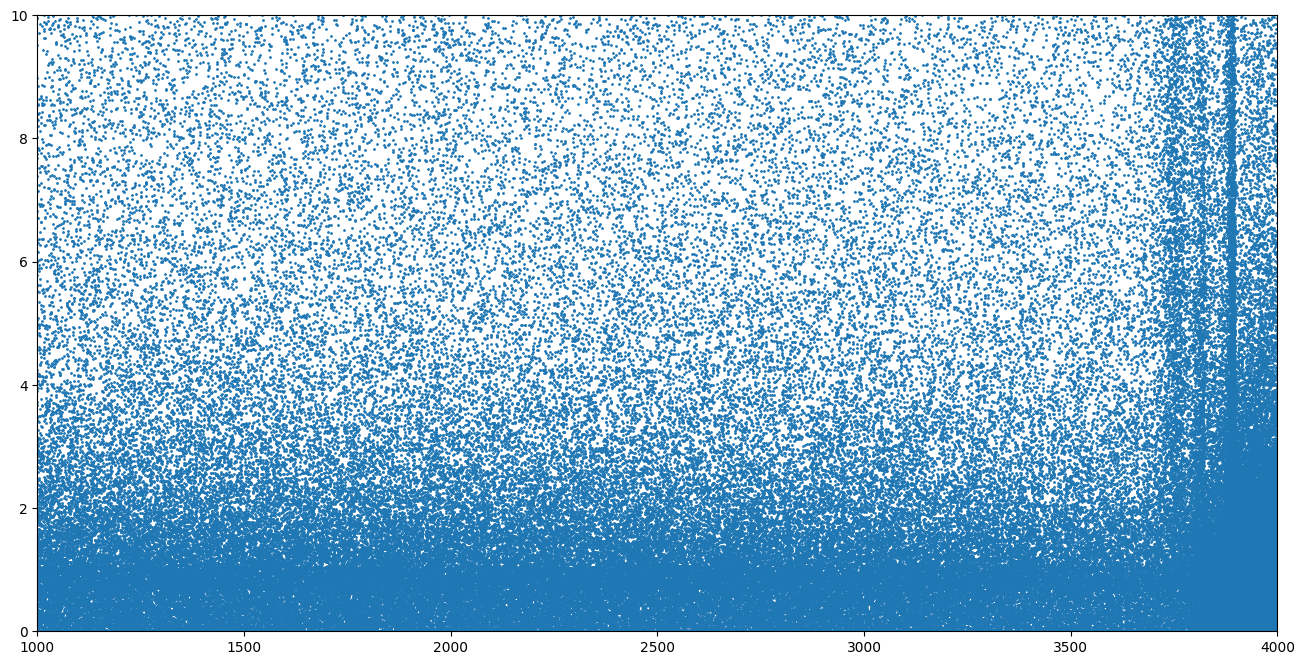

In [86]:
plt.figure(figsize=(16,8))
plt.scatter(X.transpose()[1], y, s=1)
plt.xlim(1000, 4000)
plt.ylim(0, 10)
plt.show()

In [360]:
def bin_by_x(X, y, x_range = (0,4000), step = 1, bin_width=2):
    stdevs = []
    means = []
    for x in range(x_range[0],x_range[1], step):
        subset = (X.transpose()[1]>x-bin_width/2)*(X.transpose()[1]<x+bin_width/2)
        y_subset = (y[subset])/(X.transpose()[0][subset])
        stdevs.extend(np.std(y_subset[y_subset>0]))
        means.extend(np.mean(y_subset))
    return stdevs, means

def bin_by_y(X, Y, y_range = (0,3000), step = 1, bin_width=2):
    optima = []
    stdevs = []
    means = []
    for y in range(y_range[0],y_range[1], step):
        subset = (X.transpose()[2]>y-bin_width/2)*(X.transpose()[2]<y+bin_width/2)
        y_subset = (Y[subset])/(X.transpose()[0][subset])
        obs_counts, obs_bins = np.histogram(y_subset[y_subset>0.1], bins=100)
        optima.append(obs_bins[obs_counts.argmax()])
        stdevs.append(np.std(y_subset[y_subset>0]))
        means.append(np.mean(y_subset))
    return stdevs, optima, means

def bin_by_theta(X, Y, theta_range = (0,0.6), step = 0.001, bin_width=0.002):
    stdevs = []
    means = []
    for theta in np.arange(theta_range[0],theta_range[1], step):
        subset = (X.transpose()[4]>theta-bin_width/2)*(X.transpose()[4]<theta+bin_width/2)
        y_subset = (Y[subset])/(X.transpose()[0][subset])
        stdevs.append(np.std(y_subset[y_subset>0]))
        means.append(np.mean(y_subset))
    return stdevs, means
        

In [363]:
sigma, mu = bin_by_x(X_sel,y_sel, bin_width=10, x_range=(1000,3000))

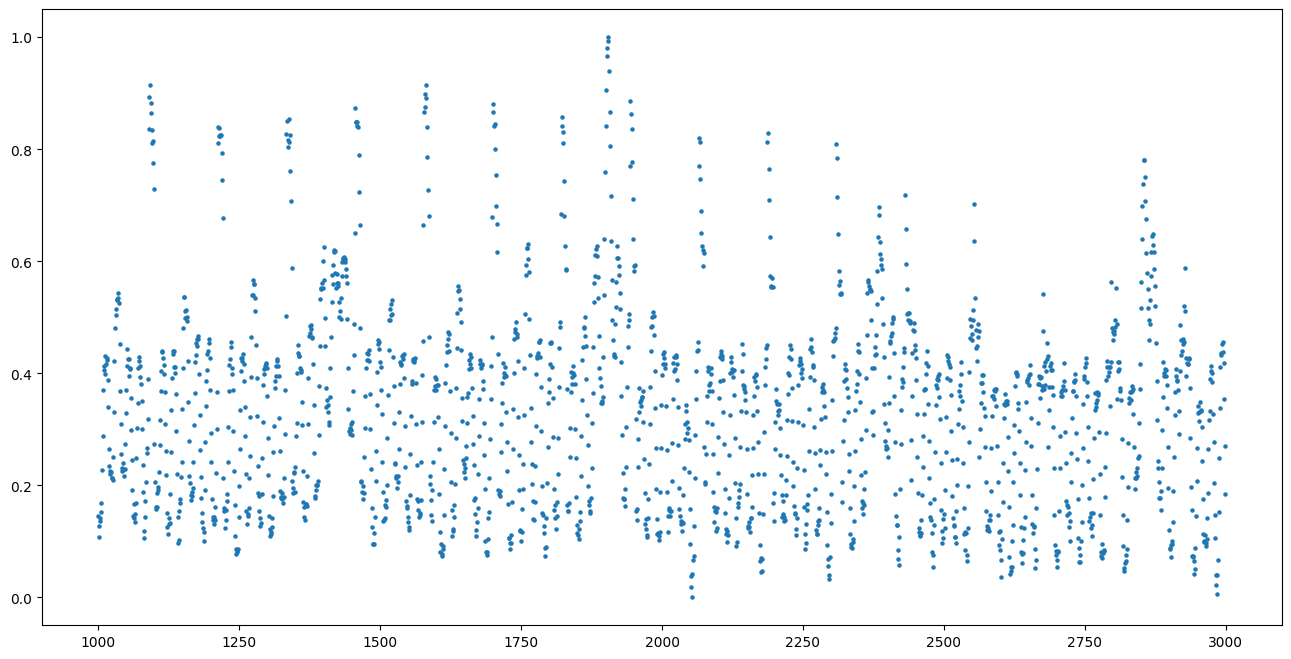

In [377]:
plt.figure(figsize=(16,8))
plt.scatter(range(1000,3000), (sigma-min(sigma))/(max(sigma)-min(sigma)), s= 5)
plt.show()

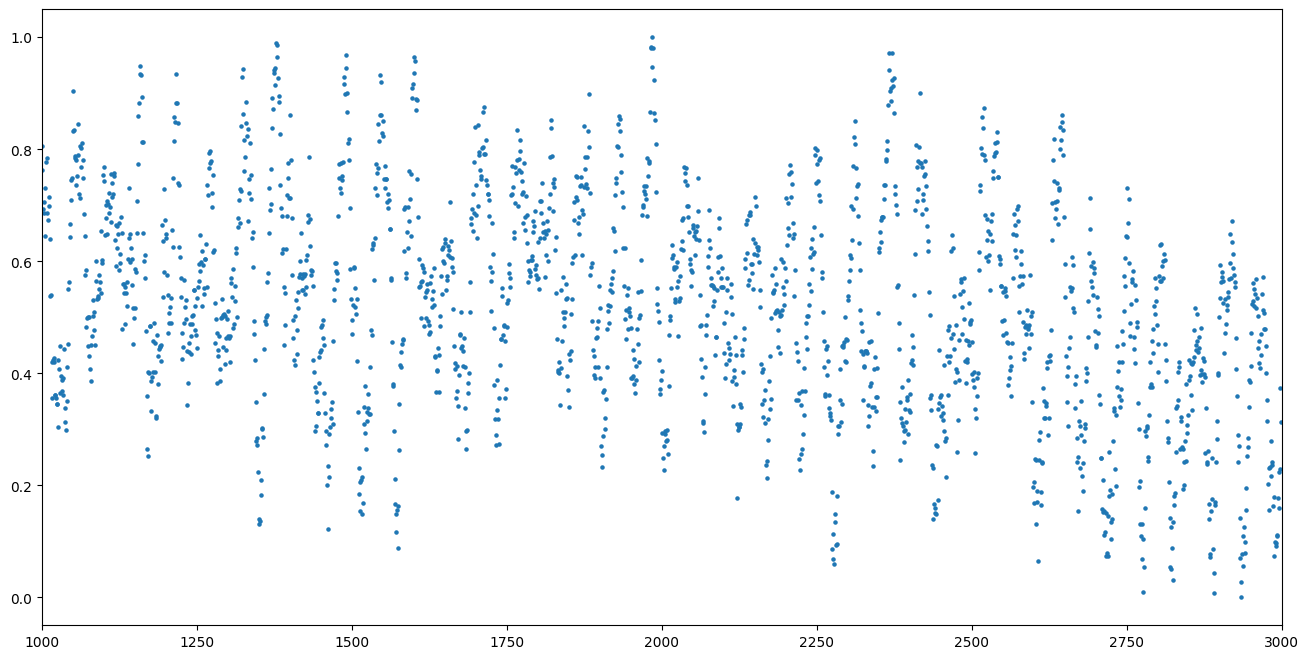

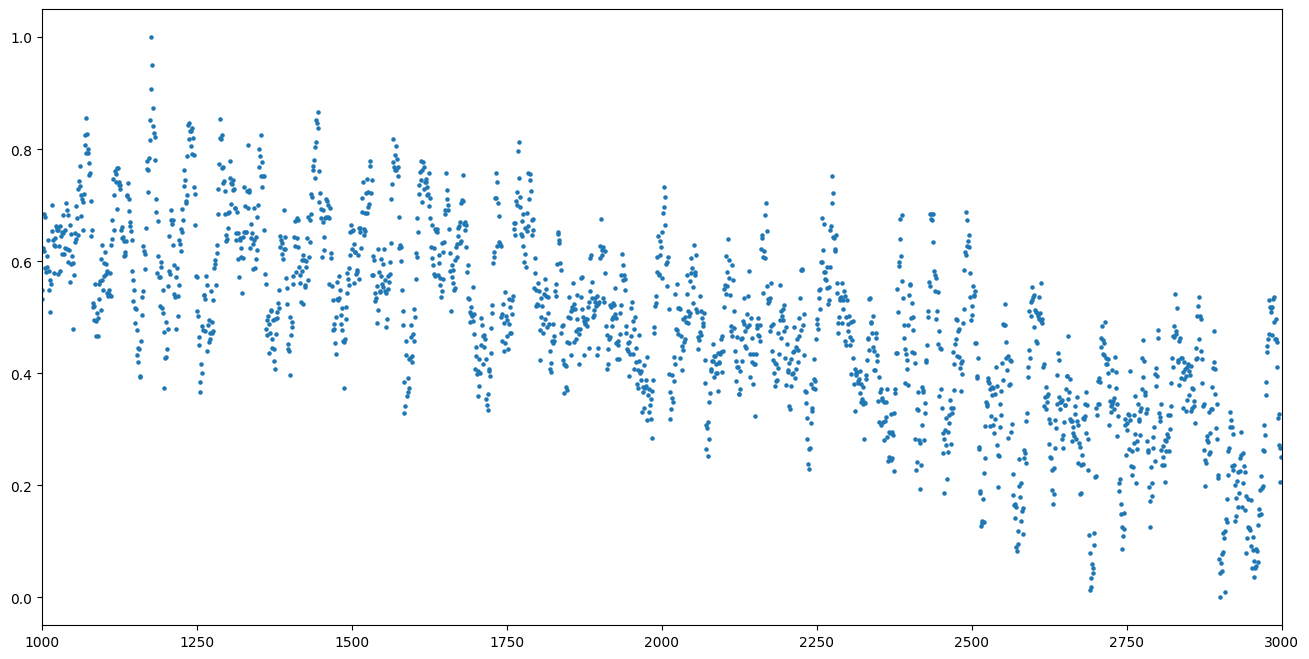

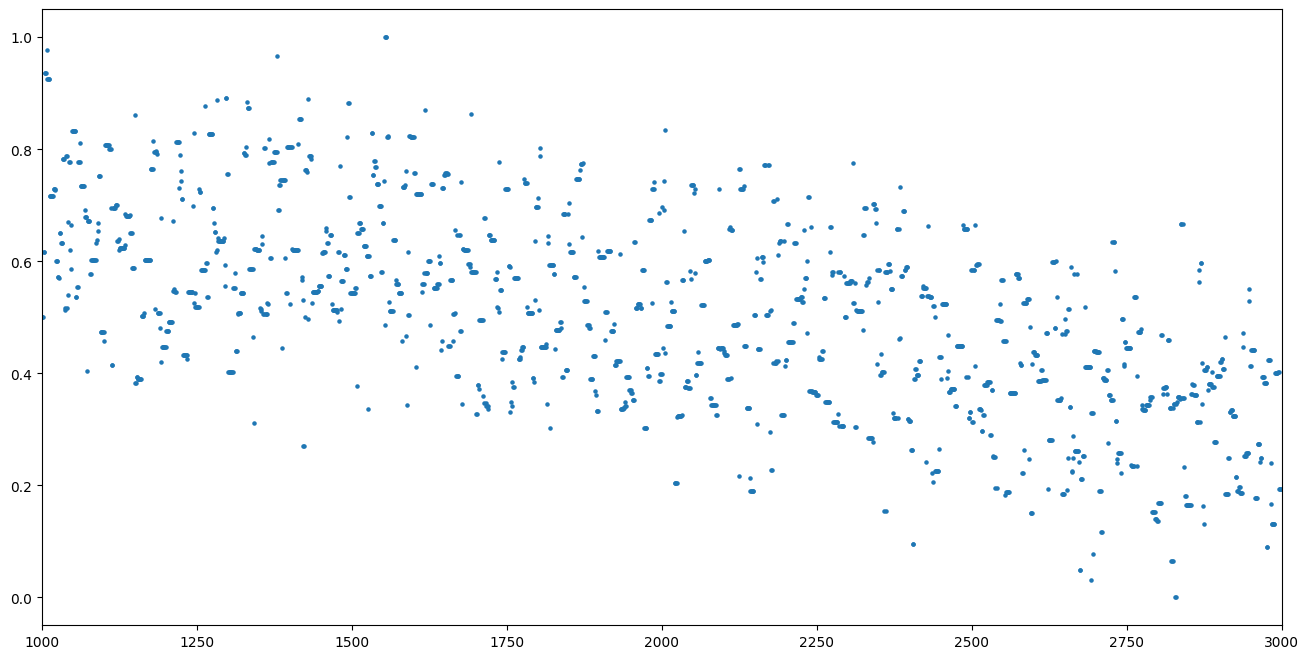

In [216]:
plt.figure(figsize=(16,8))
plt.scatter(range(1000,3000, 1), (sigma-min(sigma))/(max(sigma)-min(sigma)), s= 5)
plt.xlim(1000,3000)
#plt.ylim(0.015,0.02)
plt.show()
plt.figure(figsize=(16,8))
plt.scatter(range(1000,3000, 1), (mu-min(mu))/(max(mu)-min(mu)), s= 5)
plt.xlim(1000,3000)
#plt.ylim(0.128,0.134)
plt.show()
plt.figure(figsize=(16,8))
plt.scatter(range(1000,3000, 1), (opt-min(opt))/(max(opt)-min(opt)), s= 5)
plt.xlim(1000,3000)
plt.show()

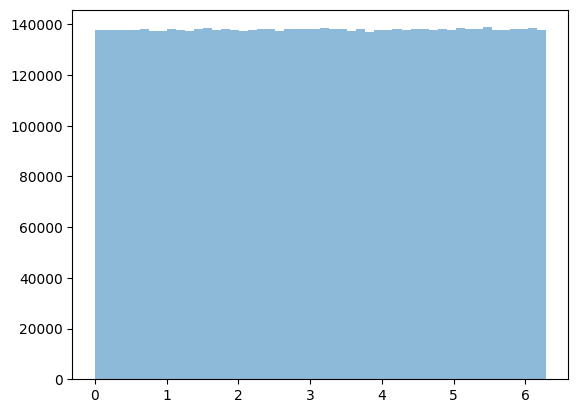

In [241]:
counts, obs = np.histogram(X_sel.transpose()[5] ,bins=50)
plt.hist(obs[:-1], obs, weights=counts, alpha=0.5)
plt.show()

In [357]:
subset = (X.transpose()[0] >1000) 

In [359]:
X_sel, y_sel = X[subset], y[subset]

In [376]:
sigma

array([0.01221733, 0.01214491, 0.01207105, ..., 0.01303706, 0.01270631,
       0.01237384], dtype=float32)

In [379]:
data = np.concatenate((y.reshape(1,-1), X.transpose()[1:])).transpose()

In [380]:
data_fft = np.fft.fft2(data)

In [381]:
sel_ind = np.random.choice(X.shape[0], 5000000)
obs = y[sel_ind]
data_fft_sub = data_fft[sel_ind]

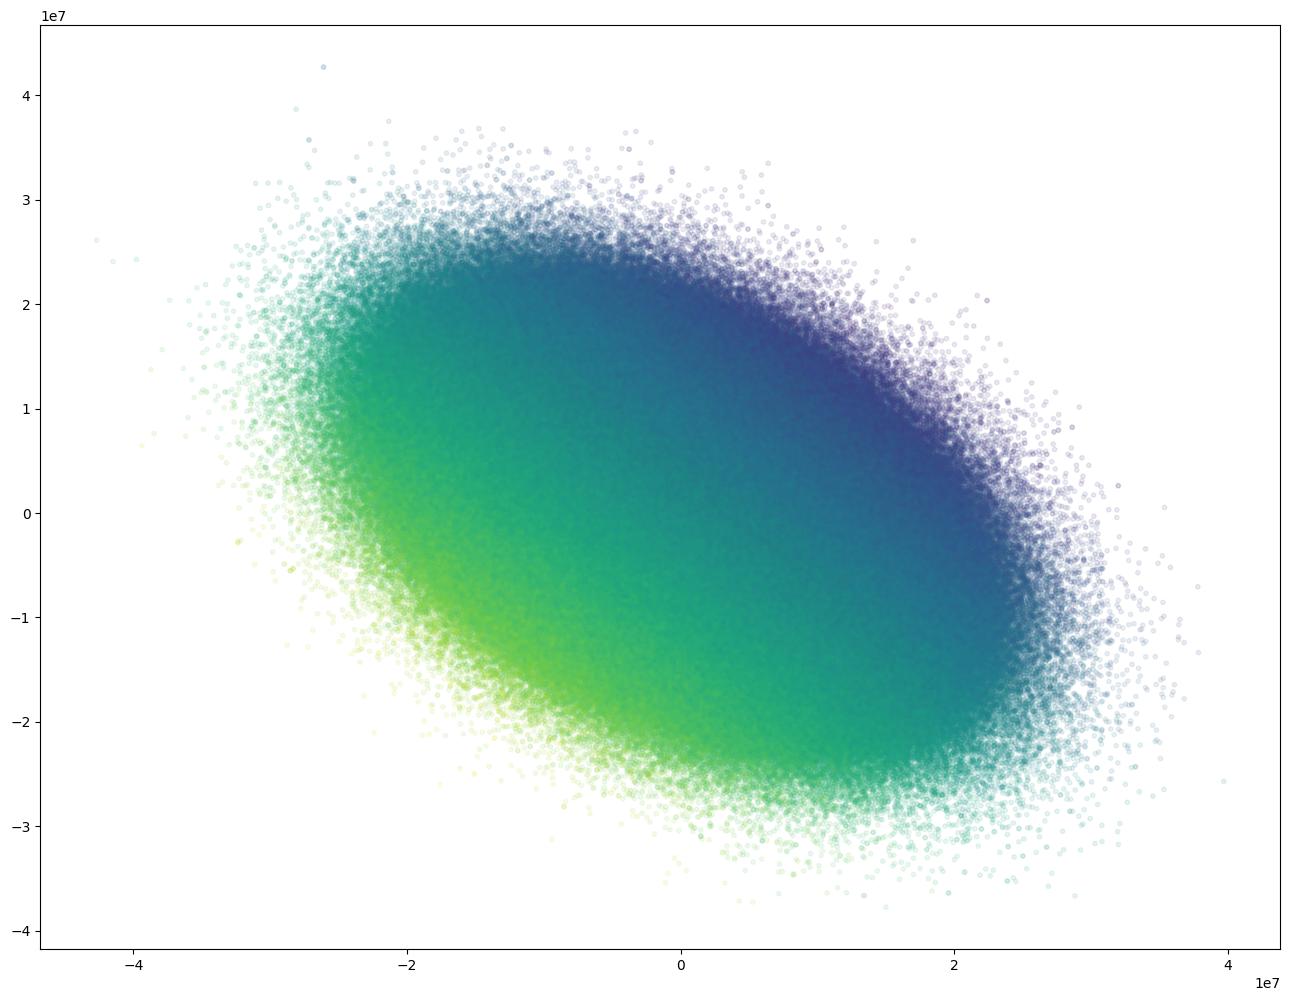

In [382]:
plt.figure(figsize=(16,12))
plt.scatter(data_fft_sub.transpose()[1].imag, data_fft_sub.transpose()[2].imag, c = data_fft_sub.transpose()[0].imag, alpha=0.1, s = 10)
plt.show()

In [307]:
#scaler = StandardScaler()
X_fourier_real = data_fft_sub[:,1:].real
y_fourier_real = data_fft_sub[:,0].real
X_fourier_imag = data_fft_sub[:,1:].imag
y_fourier_imag = data_fft_sub[:,0].imag

In [308]:
regr_real = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3), verbose =True)
regr_imag = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3), verbose =True)
regr_real.fit(X_fourier_real, y_fourier_real)
regr_imag.fit(X_fourier_imag, y_fourier_imag)

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.3s
[Pipeline] ...... (step 2 of 2) Processing sgdregressor, total=   8.5s
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.2s
[Pipeline] ...... (step 2 of 2) Processing sgdregressor, total=  15.7s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())],
         verbose=True)

In [309]:
pred_real = regr_real.predict(X_fourier_real)
pred_imag = regr_imag.predict(X_fourier_imag)
pred = pred_real + pred_imag*1j

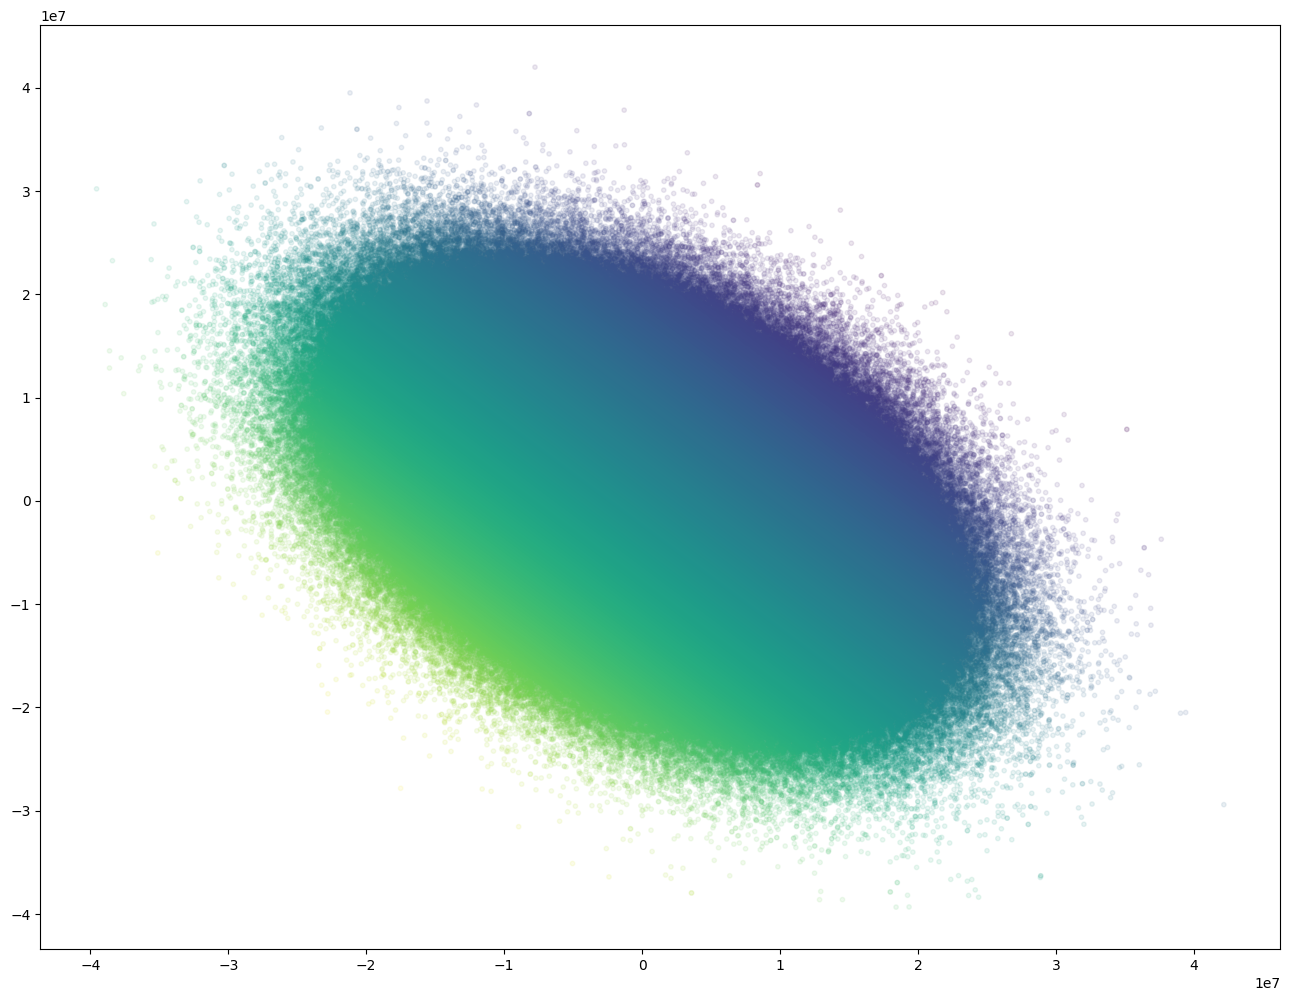

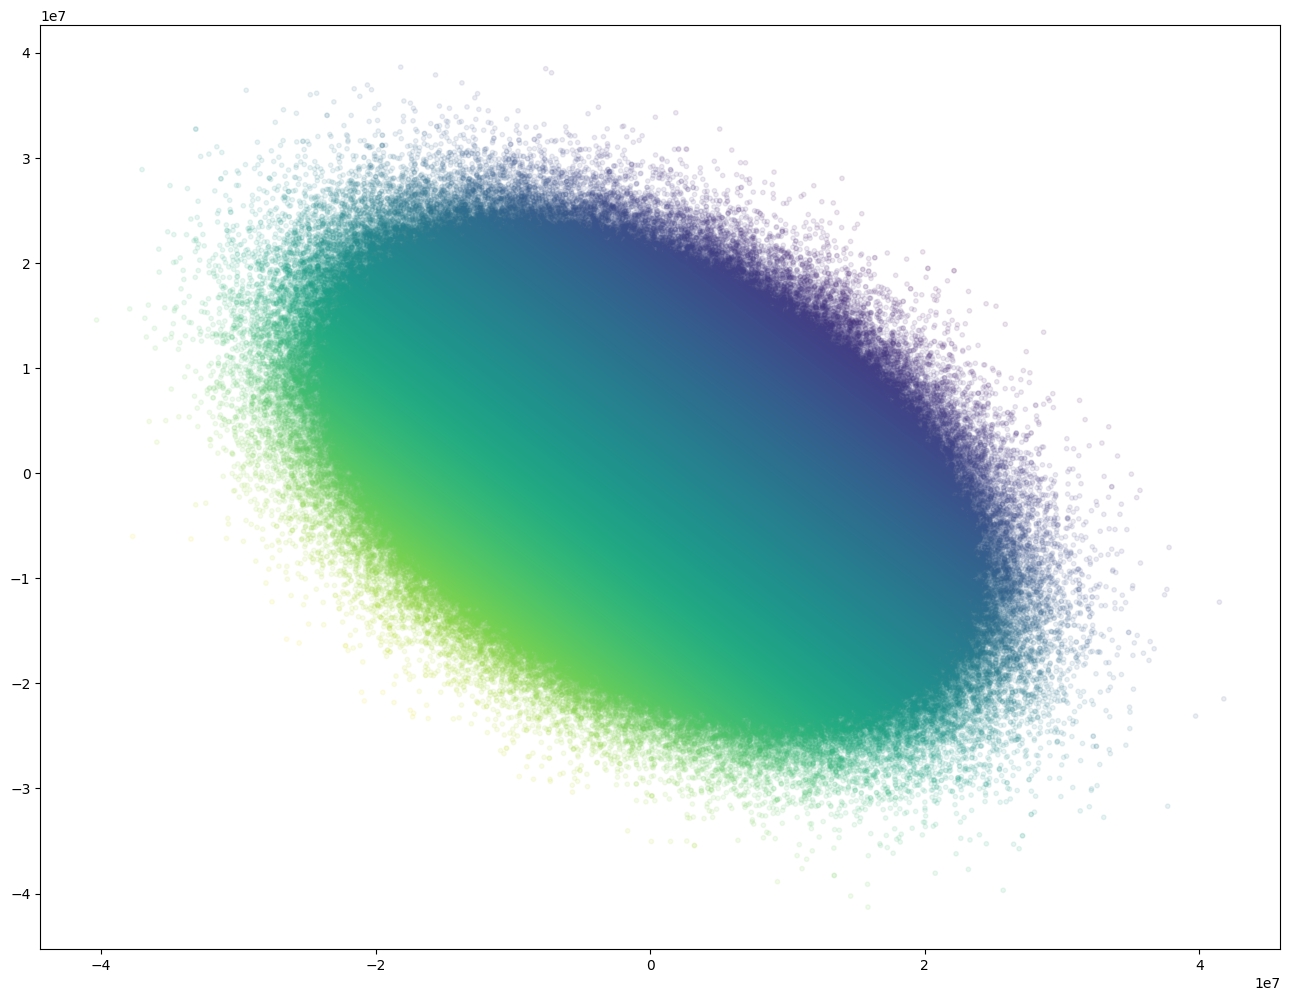

In [315]:
plt.figure(figsize=(16,12))
plt.scatter(data_fft_sub.transpose()[1].real, data_fft_sub.transpose()[2].real, c = pred.real, alpha=0.1, s = 10)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(data_fft_sub.transpose()[1].imag, data_fft_sub.transpose()[2].imag, c = pred.imag, alpha=0.1, s = 10)
plt.show()

In [327]:
np.std(pred_real), np.std(y_fourier_real)

(np.float64(6761409.696190009), np.float32(7287004.5))

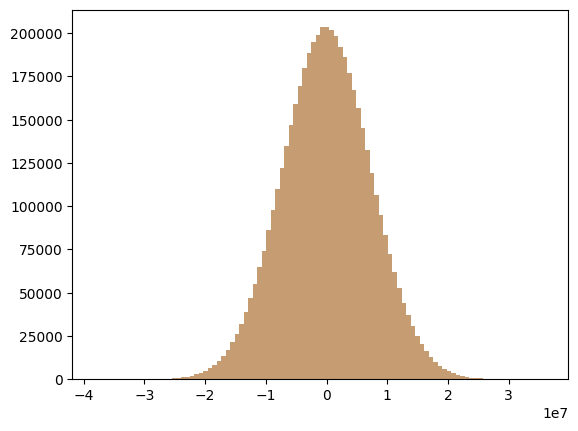

In [324]:
obs_counts, obs_bins = np.histogram(y_fourier_real, bins=100)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
pred_counts, pred_bins = np.histogram(pred_real, bins=100)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.show()

In [383]:
#pred_fft_with_inputs = np.concatenate((pred.reshape(1,-1), data_fft_sub[:,1:].transpose())).transpose()
pred_inv = np.fft.ifft2(data_fft_sub)

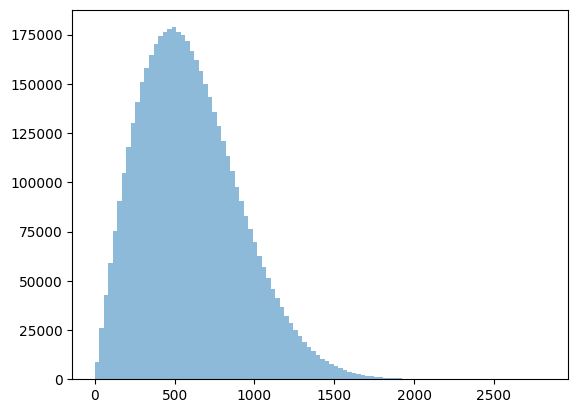

In [386]:
pred_counts, pred_bins = np.histogram(abs(pred_inv.transpose()[0]), bins=100, )
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=0.5)
plt.show()

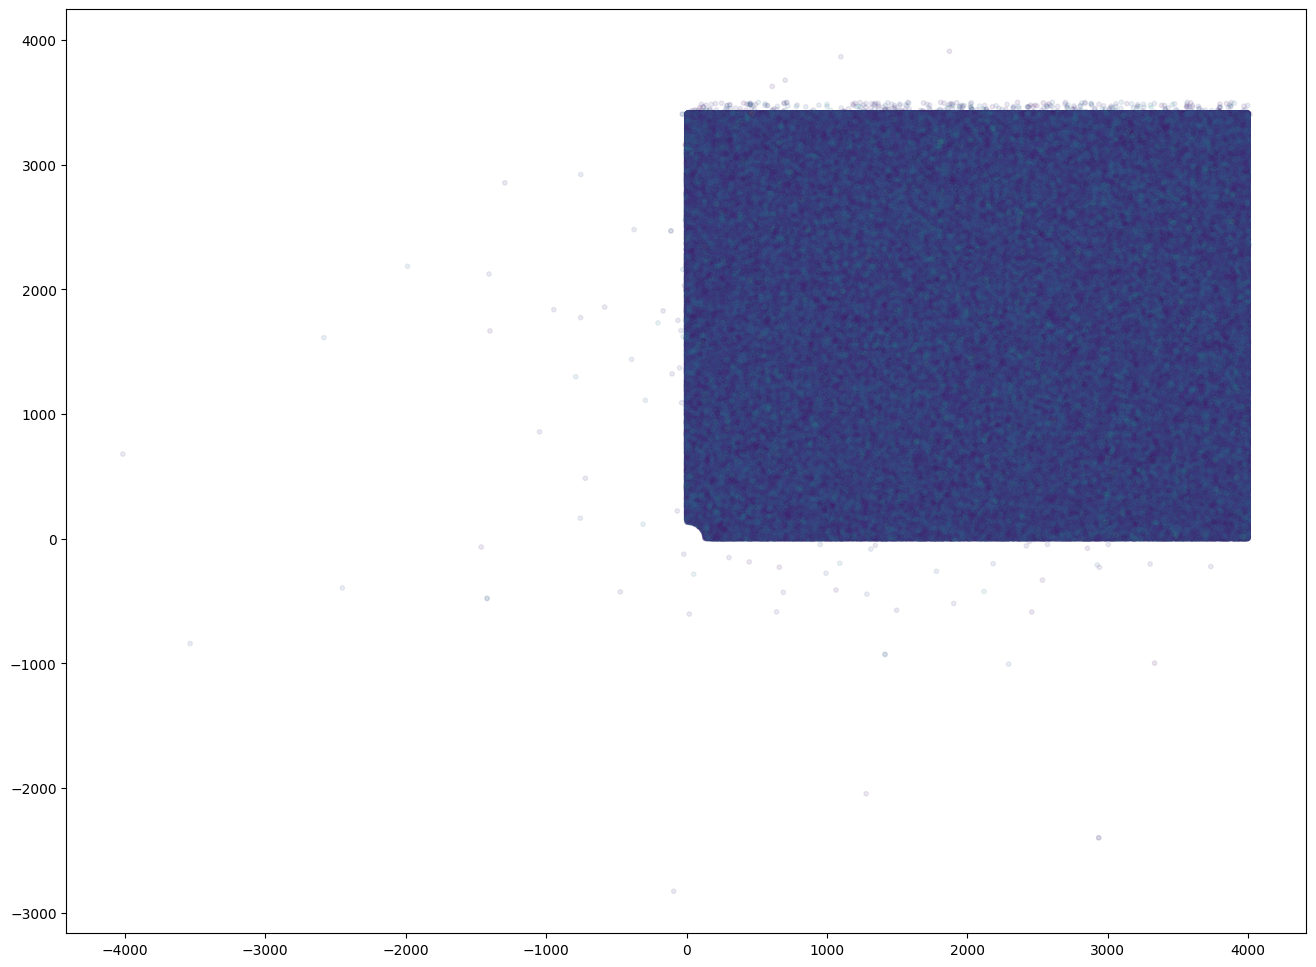

In [390]:
plt.figure(figsize=(16,12))
plt.scatter(X.transpose()[1][sel_ind], X.transpose()[2][sel_ind], c = abs(pred_inv.transpose()[0]), alpha=0.1, s = 10)
plt.show()

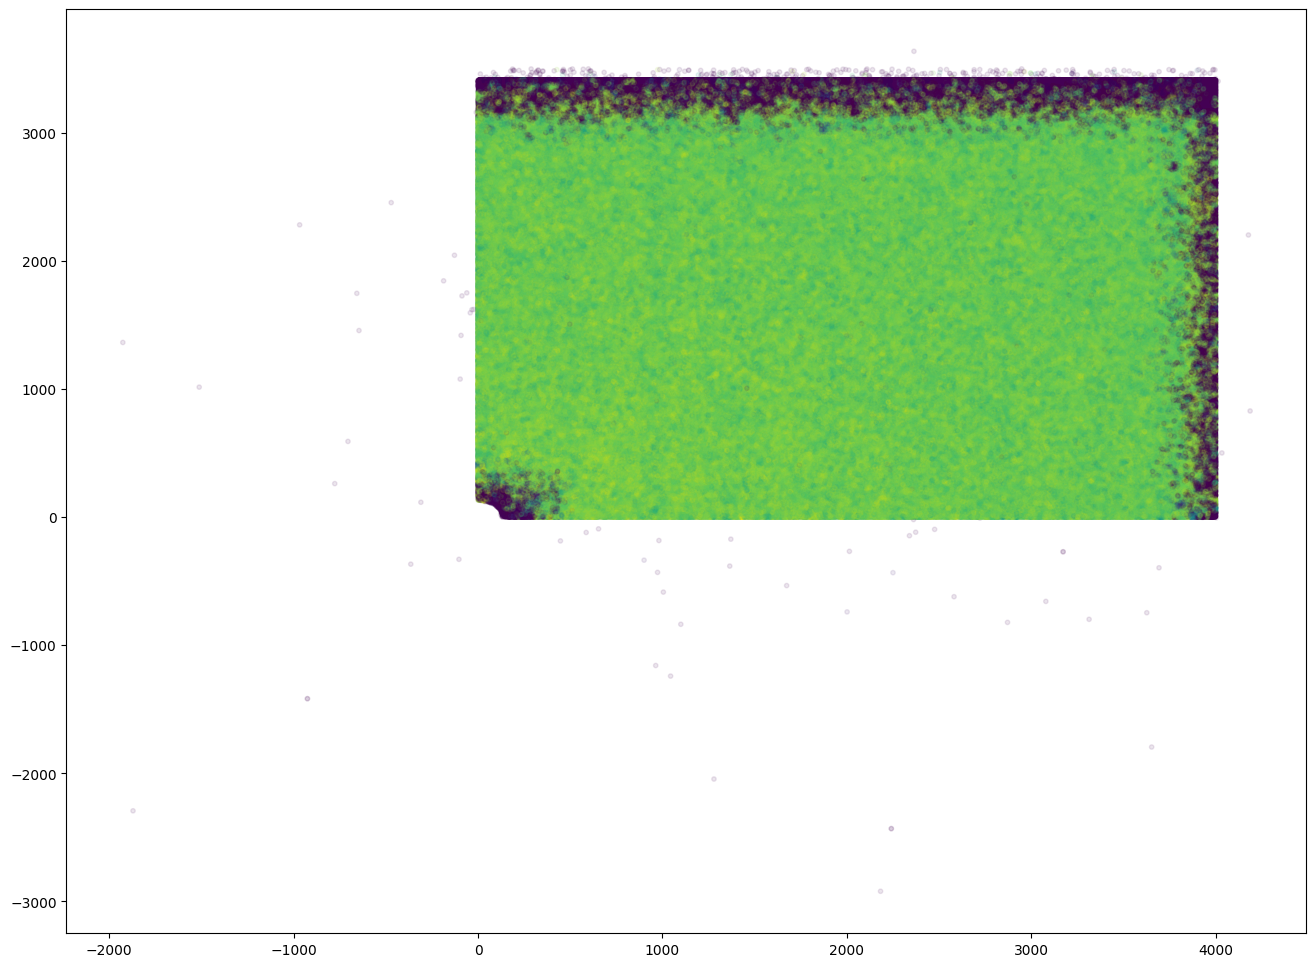

In [331]:
plt.figure(figsize=(16,12))
plt.scatter(X_sel.transpose()[1], X_sel.transpose()[2], c = abs(pred_inv.transpose()[0]), alpha=0.1, s = 10)
plt.show()

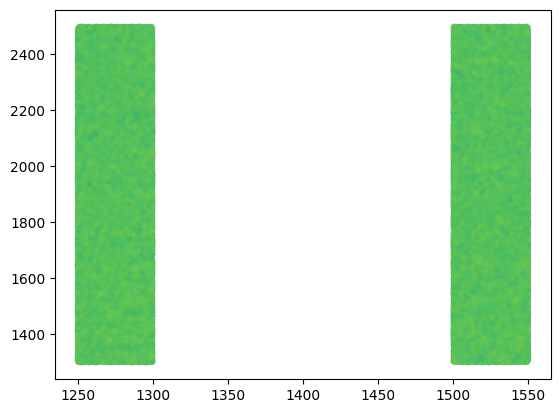

In [353]:
plt.scatter(X_sel.transpose()[1], X_sel.transpose()[2], c = y_sel, alpha=0.1, s = 10)
plt.show()

(array([6.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00, 2.0000e+00,
        3.0000e+00, 6.0000e+00, 7.0000e+00, 4.0000e+00, 6.0000e+00,
        9.0000e+00, 3.0000e+01, 1.9000e+01, 3.1000e+01, 3.4000e+01,
        6.8000e+01, 7.5000e+01, 9.9000e+01, 1.2600e+02, 1.6900e+02,
        2.3300e+02, 3.6600e+02, 4.9200e+02, 7.2700e+02, 1.0440e+03,
        1.6750e+03, 2.7590e+03, 5.0500e+03, 1.0312e+04, 2.5832e+04,
        6.3346e+04, 8.9155e+04, 3.4658e+04, 3.6520e+03, 5.6500e+02,
        2.1500e+02, 6.6000e+01, 2.7000e+01, 1.1000e+01, 8.0000e+00]),
 array([0.        , 0.00340996, 0.00681992, 0.01022988, 0.01363984,
        0.0170498 , 0.02045976, 0.02386972, 0.02727969, 0.03068965,
        0.03409961, 0.03750957, 0.04091953, 0.04432949, 0.04773945,
        0.05114941, 0.05455937, 0.05796933, 0.06137929, 0.06478926,
        0.06819922, 0.07160918, 0.07501914, 0.

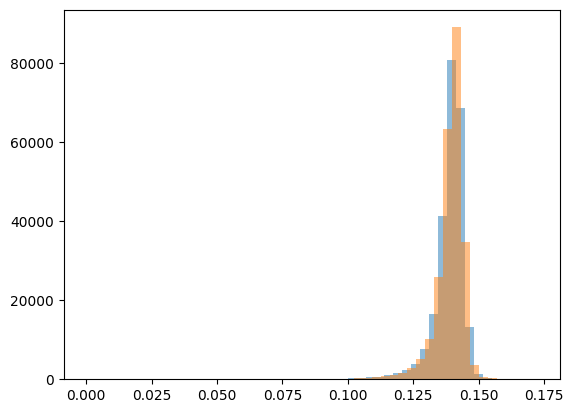

In [199]:
obs_counts, obs_bins = np.histogram((y/X.transpose()[0])[(X.transpose()[0]>1000)*(X.transpose()[1]>1400)*(X.transpose()[2]>400)*(X.transpose()[2]<2500)*(X.transpose()[1]<1500)], bins=50)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
obs_counts, obs_bins = np.histogram((y/X.transpose()[0])[(X.transpose()[0]>1000)*(X.transpose()[1]>1500)*(X.transpose()[2]>400)*(X.transpose()[2]<2500)*(X.transpose()[1]<1600)], bins=50)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)

In [260]:
pred = neigh.predict(X)
obs = y

In [291]:
def plot_hist_by_p(n_bins, p_max, plot_seperate = False):
    plt.figure(figsize=(16,8))
    for i in range(2,10):
        subset = (X.transpose()[0]>i*1000-100)*(X.transpose()[0]<i*1000+100)
        pred_counts, pred_bins = np.histogram(pred[subset], bins=n_bins, range=(0,p_max))
        obs_counts, obs_bins = np.histogram(obs[subset], bins=n_bins, range=(0,p_max))
        plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=0.75)
        plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.25)
        if plot_seperate:
            plt.show()
    if not plot_seperate:
        plt.show()

    plt.figure(figsize=(16,8))
    for i in range(2,10):
        subset = (X.transpose()[0]>i*1000-100)*(X.transpose()[0]<i*1000+100)
        pred_counts, pred_bins = np.histogram(pred[subset], bins=n_bins, range=(0,p_max))
        obs_counts, obs_bins = np.histogram(obs[subset], bins=n_bins, range=(0,p_max))
        plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=0.75)
        plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.25)
        if plot_seperate:
            plt.yscale('log')
            plt.show()
    if not plot_seperate:
        plt.yscale('log')
        plt.show()

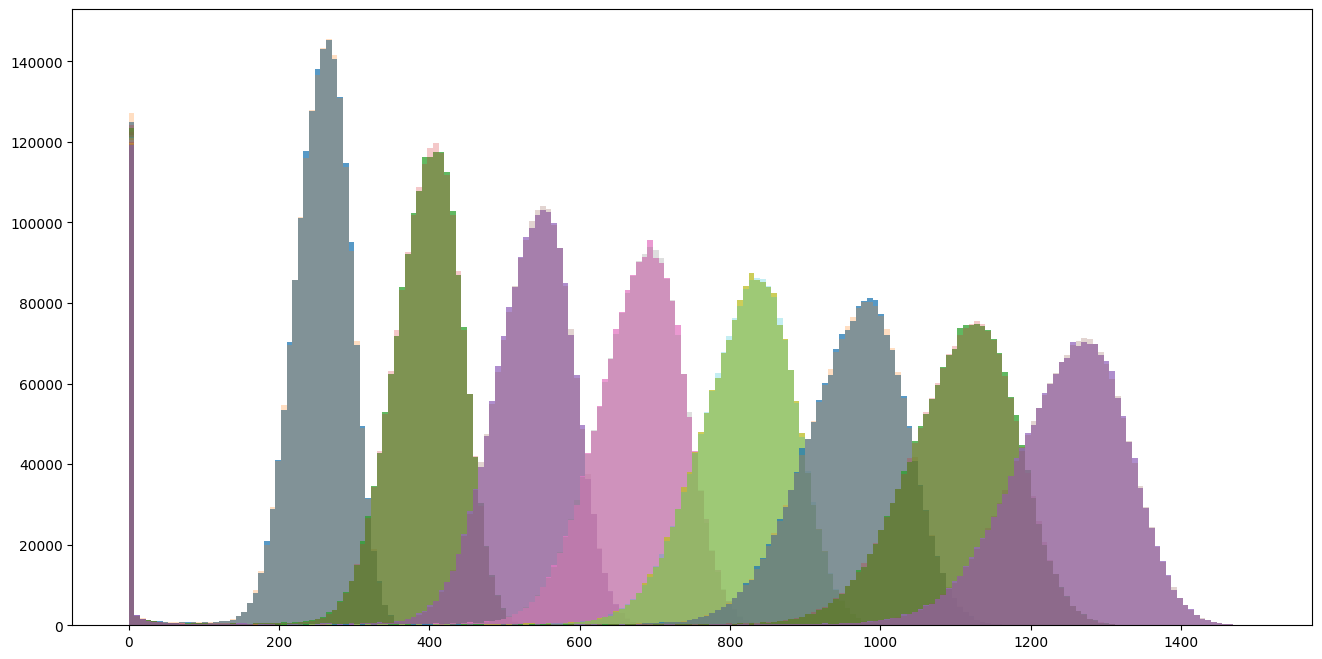

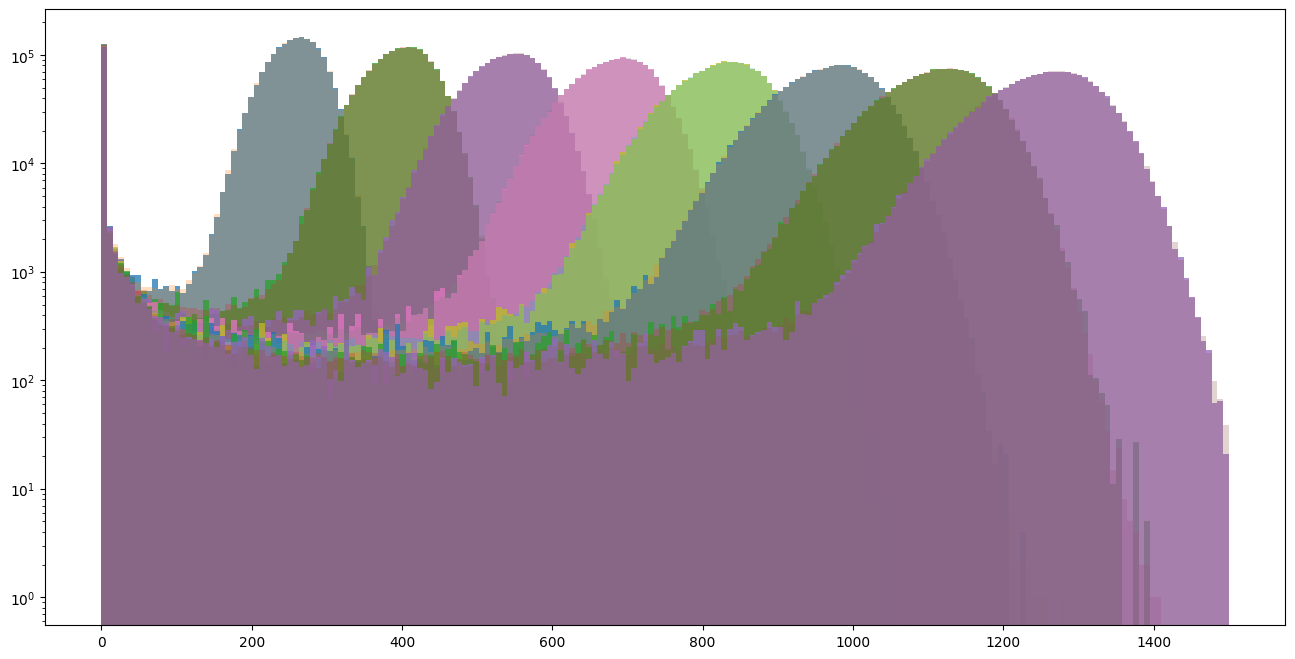

In [293]:
plot_hist_by_p(200, 1500)

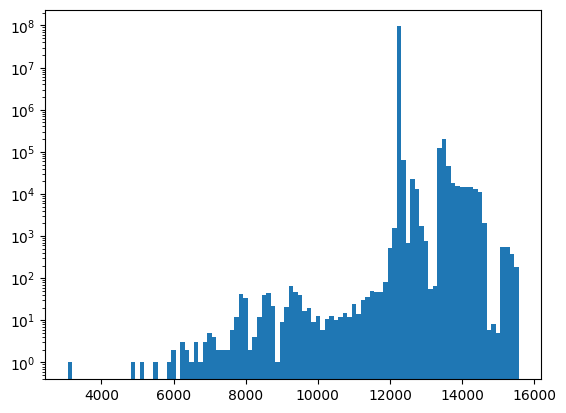

In [313]:
counts, bins = np.histogram(X.transpose()[3], bins=100)
plt.hist(bins[:-1], bins, weights=counts, alpha=1)
plt.yscale('log')
plt.show()

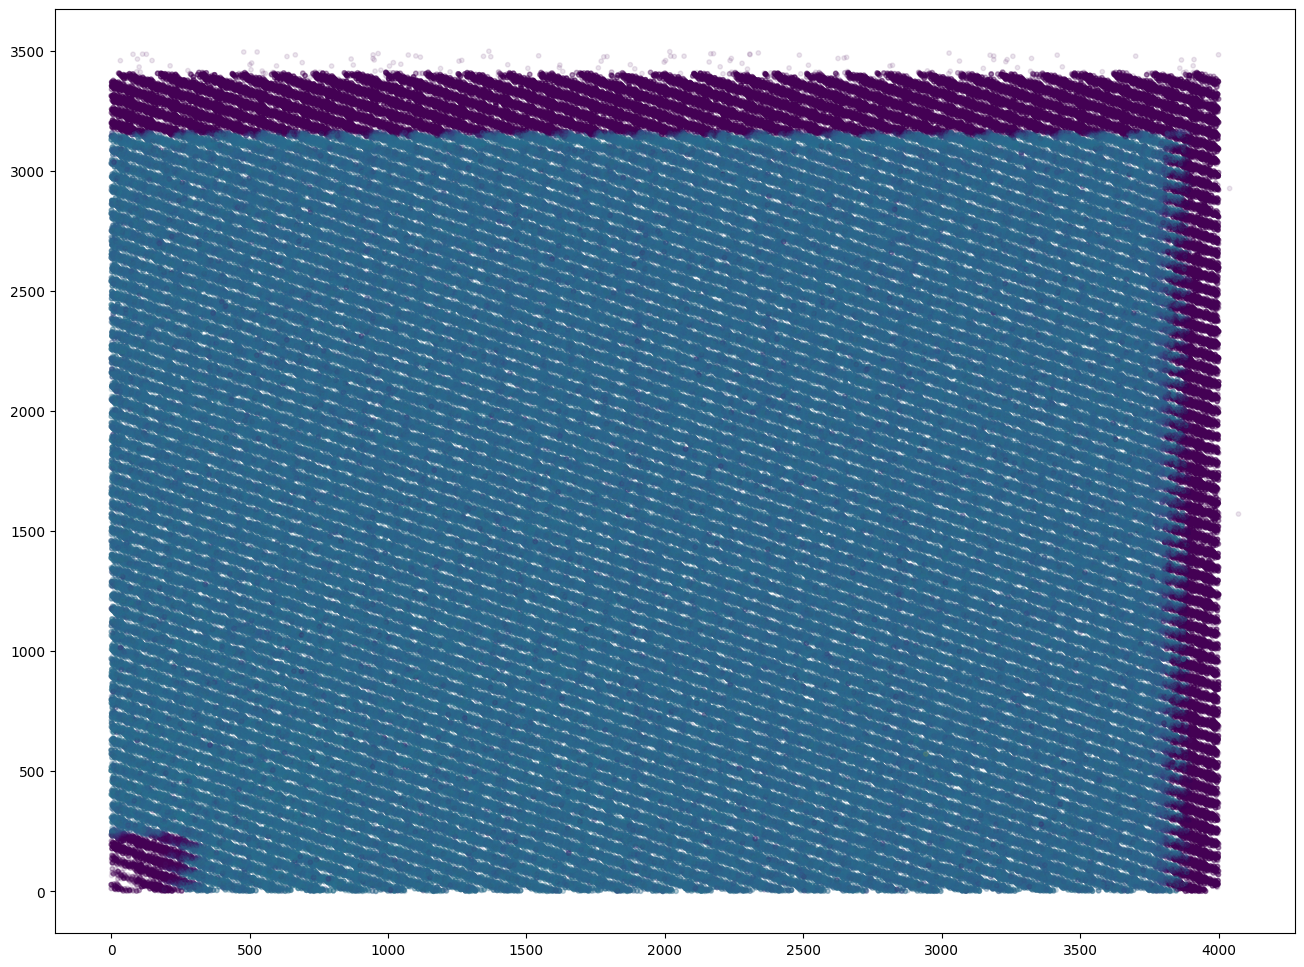

In [321]:
plt.figure(figsize=(16,12))
plt.scatter(X_sel.transpose()[1], X_sel.transpose()[2], c = y_sel/X_sel.transpose()[0], alpha=0.1, s = 10)
plt.show()

In [377]:
clf = LocalOutlierFactor(n_neighbors=5, novelty=True)

In [378]:
clf.fit(np.array([X_sel.transpose()[1], X_sel.transpose()[2], y_sel]).transpose())

LocalOutlierFactor(n_neighbors=5, novelty=True)

In [381]:
x = np.linspace(0, 1000, 8232247)
samples = np.random.choice(x, size=8232247, p=double_cball(x,*params)/np.sum(double_cball(x,*params))) 

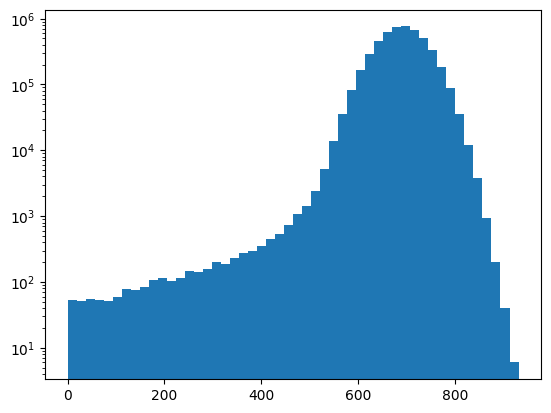

In [364]:
sample_counts, sample_bins = np.histogram(samples, bins=50)
plt.hist(sample_bins[:-1], sample_bins, weights=sample_counts, alpha=1)
plt.yscale('log')

In [382]:
pred_out = clf.predict(np.array([X_sel.transpose()[1], X_sel.transpose()[2], samples]).transpose())

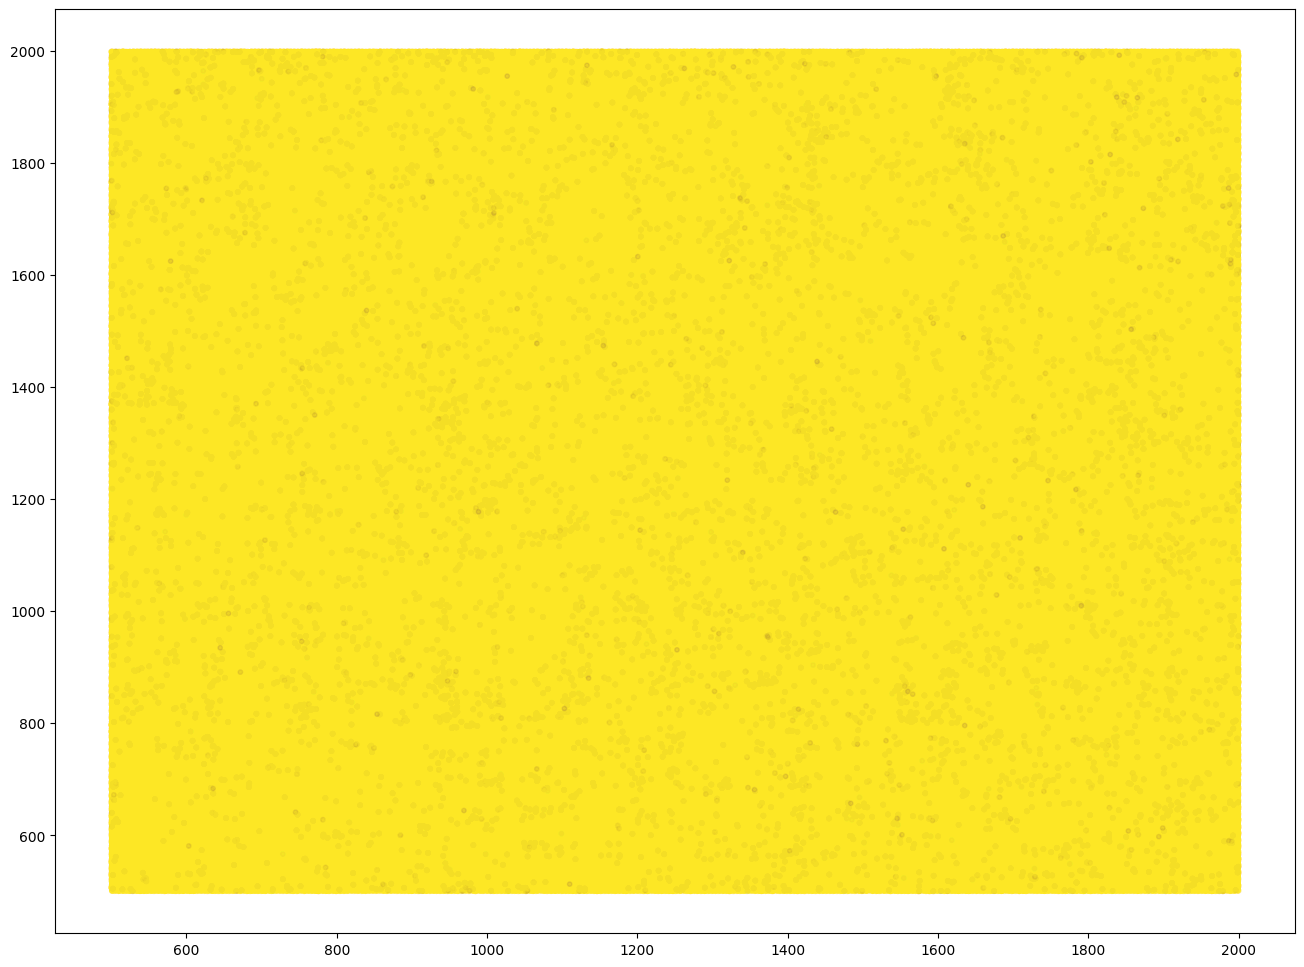

In [383]:
plt.figure(figsize=(16,12))
plt.scatter(X_sel.transpose()[1], X_sel.transpose()[2], c = pred_out, alpha=0.1, s = 10)
plt.show()

In [380]:
X_sel.shape

(8232247, 6)